### Questions Type Categories

In this notebook we are going to use this [dataset](https://www.kaggle.com/ananthu017/question-classification?rvi=1) from kaggle to perform question type classification.

I've already downloaded the dataset and uploaded it on my google drive so that i can easly load it here in google colab.

In this first notebook we are going to use `RNNs` to perform text classification with 1 label. Later on we will use Conv Nets to perform this task.

### Imports

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import csv, json, time
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

tf.__version__

'2.5.0'

### GPU

In [2]:
devices = tf.config.list_physical_devices("GPU")
try:
  tf.config.experimental.set_visible_devices(devices[0], "GPU")
  print("GPU set")
except RuntimeError as e:
  print(e)

GPU set


### SEED

In [3]:
SEED = 42
tf.random.set_seed(
    SEED
)
np.random.seed(SEED)

### Mounting the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Data

We will load the data from a single csv file. We are going to split that csv file into three file, the:
```
train.csv
test.csv
val.csv
```
And then save these files

In [5]:
base_path = '/content/drive/MyDrive/NLP Data/'
os.listdir(base_path)

['questions-classification']

In [6]:
data_path = os.path.join(base_path, 'questions-classification')
os.listdir(data_path)

['Question_Classification_Dataset.csv']

In [7]:
file_path = os.path.join(data_path, "Question_Classification_Dataset.csv")

### Read the data into a dataframe

In [8]:
dataframe = pd.read_csv(file_path)
dataframe.head()

,Unnamed: 0,Questions,Category0,Category1,Category2
0,0,How did serfdom develop in and then leave Russ...,DESCRIPTION,DESC,manner
1,1,What films featured the character Popeye Doyle ?,ENTITY,ENTY,cremat
2,2,How can I find a list of celebrities ' real na...,DESCRIPTION,DESC,manner
3,3,What fowl grabs the spotlight after the Chines...,ENTITY,ENTY,animal
4,4,What is the full form of .com ?,ABBREVIATION,ABBR,exp


### Checking for null values

In [9]:
dataframe.isnull().any()

Unnamed: 0    False
Questions     False
Category0     False
Category1     False
Category2     False
dtype: bool

### Splitting the sets

In [10]:
train, valid = train_test_split(dataframe, test_size=.2)
train, test = train_test_split(train, test_size=.2)

In [11]:
len(train), len(test), len(valid)

(3488, 873, 1091)

Now we have `~3K` train data, `~800` test data and `~1K` validation data, Let's save this in separate files.

In [12]:
val_path = "val.csv"
test_path = "test.csv"
train_path = "train.csv"

valid.to_csv(os.path.join(data_path, val_path), index=False)
test.to_csv(os.path.join(data_path, test_path), index=False)
train.to_csv(os.path.join(data_path, train_path), index=False)

print("files saved")

files saved


### Loading the files

In [13]:
train_dataframe = pd.read_csv(
    os.path.join(data_path, train_path)
)
val_dataframe = pd.read_csv(
    os.path.join(data_path, val_path)
)
test_dataframe = pd.read_csv(
    os.path.join(data_path, test_path)
)

In [14]:
train_dataframe.iloc[0]

Unnamed: 0                                2306
Questions     What does Salk vaccine prevent ?
Category0                               ENTITY
Category1                                 ENTY
Category2                               dismed
Name: 0, dtype: object

### Question Classes

In [15]:
train_dataframe.Category0.unique()

array(['ENTITY', 'NUMERIC', 'HUMAN', 'LOCATION', 'DESCRIPTION',
       'ABBREVIATION'], dtype=object)

As you can see we have `6` different categories for these questions which are:
```
categories = ['ENTITY', 'DESCRIPTION', 'NUMERIC', 'HUMAN', 'LOCATION',
       'ABBREVIATION']
```

For now we are interested in the question and the class the question belongs to so we are going to target the following columns:

```
1. Questions
2. Category0
```

### Features and Labels

In [16]:
train_features = train_dataframe.Questions.values
train_labels = train_dataframe.Category0.values

test_features = test_dataframe.Questions.values
test_labels = test_dataframe.Category0.values

val_features = val_dataframe.Questions.values
val_labels = val_dataframe.Category0.values


### Label Encoding.

We are going to create encode the labels to numerical represantation using the `sklearn` `LabelEncoder` class.

In [17]:
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)

LabelEncoder()

In [18]:
train_labels = label_encoder.transform(train_labels)
test_labels = label_encoder.transform(test_labels)
val_labels = label_encoder.transform(val_labels)

In [96]:
class_names = label_encoder.classes_
class_names 

array(['ABBREVIATION', 'DESCRIPTION', 'ENTITY', 'HUMAN', 'LOCATION',
       'NUMERIC'], dtype=object)

In [19]:
train_labels[:10]

array([2, 5, 3, 3, 3, 2, 5, 5, 3, 4])

### Next we are going to `one_hot_encode` labels.

We are only going to `one_hot` encode the train and validation labels. The test set we don't even care about it since we will be using it for model inference. I'm going to use the `numpy` method `eye`. You can use the `sklearn` ``OneHotEncoder`` class or the `tensorflow` method `one_hot`. To make this simple i will create a helper function that will encode the labels to one hot for me. I will then map through labels applying the `one_hot()` function to each label in the labels list.

In [21]:
def one_hot(index, depth=6): # 6 classes
  return np.eye(depth, dtype=np.float32)[index]

one_hot(2)

array([0., 0., 1., 0., 0., 0.], dtype=float32)

In [22]:
train_labels_one_hot = np.array(list(map(one_hot, train_labels)))
val_labels_one_hot = np.array(list(map(one_hot, val_labels)))

In [23]:
train_labels_one_hot[0]

array([0., 0., 1., 0., 0., 0.], dtype=float32)

### Features

 For now we are done with labels. In our case our feature is a question. All we need to do in this dataset is to create a helper function that will convert the text to lower case that's all we need. 

 After that we will then prepare/preprocess the train and validation features for the model.

In [24]:
to_lower = lambda sent: sent.lower()

In [25]:
train_features = np.array(
    list(
        map(to_lower, train_features)
    )
)
val_features= np.array(
    list(
        map(to_lower, val_features)
    )
)

In [26]:
train_features[:2]

array(['what does salk vaccine prevent ?',
       "how many times a day should you take a prescription marked `` q.i.d . '' ?"],
      dtype='<U196')

### Preprocessing Features(Questions)

1. Create a vocabulary
2. Create a `stoi` from each sentencs
3. pad the sentences to have the same size

**Note** - During creation of the vocabulary we are going to use the `train` set. The model should not have an idea about the validation set, because we want the validation set to represent the test set as mush as possible.

### Vocab size, (aka) the number of unique words.

I'm going to use spacy to tokenize each sentence and then we count number of unique words in the train set.

In [27]:
from collections import Counter
from nltk.tokenize import word_tokenize

In [34]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [35]:
train_features[0]

'what does salk vaccine prevent ?'

In [36]:
counter = Counter()
for sent in list(train_features):
  words = word_tokenize(sent)
  for word in words:
    counter[word] += 1
counter.most_common(9)

[('?', 3418),
 ('the', 2383),
 ('what', 2159),
 ('is', 1084),
 ('of', 988),
 ('in', 751),
 ('a', 675),
 ('how', 503),
 ("'s", 447)]

In [38]:
counter.most_common(20)

[('?', 3418),
 ('the', 2383),
 ('what', 2159),
 ('is', 1084),
 ('of', 988),
 ('in', 751),
 ('a', 675),
 ('how', 503),
 ("'s", 447),
 ('was', 416),
 ('to', 406),
 ('who', 399),
 (',', 370),
 ('for', 298),
 ('are', 275),
 ('and', 271),
 ('does', 255),
 ("''", 251),
 ('``', 249),
 ('did', 240)]

In [ ]:
vocab_size = len(counter)
vocab_size

We have `~6K` unique words in the train set. Next we are going to create word vectors.

### Word vectors

In [40]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [41]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_features)

In [42]:
word_indices = tokenizer.word_index
word_indices_reversed = dict([
    (v, k) for (k, v) in word_indices.items()
])

### Helper functions

We will create some helper function that converts sequences to text and text to sequences. These function will be used for inference later on.

In [43]:
def seq_to_text(sequences):
  return " ".join(word_indices_reversed[i] for i in sequences )

def text_to_seq(sent):
  words = word_tokenize(sent.lower())
  sequences = []
  for word in words:
    try:
      sequences.append(word_indices[word])
    except:
      sequences.append(0)
  return sequences

### Pretrained embeding weights

Since this model is using RNN's we are going to use the `pretrained glove.6B` word embeddings. I've already uploaded these word embedding on my google colab so that we can load them as follows

In [47]:
embedding_path = "/content/drive/MyDrive/NLP Data/glove.6B/glove.6B.100d.txt"


In [48]:
embedding_dict = dict()
with open(embedding_path, encoding="utf8") as glove:
  for line in glove:
    records = line.split();
    word = records[0]
    vectors = np.asarray(records[1: ], dtype=np.float32)
    embedding_dict[word] = vectors

In [49]:
print(len(embedding_dict))
embedding_dict["what"].shape

400000


(100,)

### But wait? `40000` words? Where are they comming from?
Okay don't panic we will create the embedding matrix that will suit our vocab_size next.

### Embedding matrix
We will then create an embedding matrix that will suit our data.

In [50]:
embedding_matrix = np.zeros((vocab_size, 100))

for word, index in word_indices.items():
  vector = embedding_dict.get(word)
  if vector is not None:
    try:
      embedding_matrix[index] = vector
    except IndexError or Exception:
      pass

In [ ]:
len(embedding_matrix)

Now the `embedding_matrix` suits our data which has `6592` words.

### Creating Sequences

In [52]:
train_sequences = tokenizer.texts_to_sequences(train_features)
val_sequences = tokenizer.texts_to_sequences(val_features)

In [53]:
val_sequences[0], val_features[0]

([2, 39, 3, 364, 36, 401], 'what city is served by tempelhol airport ?')

### Testing our helper functions

In [54]:
seq_to_text(val_sequences[0])

'what city is served by airport'

In [55]:
text_to_seq("this is why the unknownnnn word ?")

[456, 3, 45, 1, 0, 70, 0]

### Pad sequences

Our final step is to pad our suquences to have the same length. We are going to do this on the train and validation sets only.

In [56]:
max_words = 100

train_tokens_padded = pad_sequences(
    train_sequences, 
    maxlen=max_words, 
    padding="post", 
    truncating="post"
)
val_tokens_padded = pad_sequences(
    val_sequences, 
    maxlen=max_words, 
    padding="post", 
    truncating="post"
)

### Building the model.

Model Achitecture.

````
                [ Embedding Layer]
                        |
                        |
[ LSTM ] <---- [Bidirectional Layer] ----> [GRU] (forward_layer)
 (backward_layer)       |
                        |
        [  Gated Recurrent Unit  (GRU)  ]
                        |
                        |
        [ Long Short Term Memory (LSTM) ]
                        |
                        |
                [ Flatten Layer / GlobalAveragePooling1D]
                        |
                        |
                 [Dense Layer 1]
                        |
                        | 
                   [ Dropout ]
                        |
                        |   
                 [Dense Layer 2]
                        |
                        | 
                   [ Dropout ]
                        |
                        |   
                 [Dense Layer 3]
                        |
                        | 
                   [ Dropout ]
                        |
                        |
                 [Dense Layer 3] (output [6 classes])
````

In [65]:
forward_layer = keras.layers.GRU(
   128, return_sequences=True, dropout=.5,
   name="gru_forward_layer"
)
backward_layer = keras.layers.LSTM(
   128, return_sequences=True, dropout=.5,
   go_backwards=True, name="lstm_backward_layer"
)

question_category_model = keras.Sequential([
      keras.layers.Embedding(
        vocab_size, 100, 
        input_length=max_words,
        weights=[embedding_matrix], 
        trainable=True,
        name = "embedding_layer"
      ),
      keras.layers.Bidirectional(
        forward_layer,
        backward_layer = backward_layer,
        name= "bidirectional_layer"
      ),
      keras.layers.GRU(
          512, return_sequences=True,
          dropout=.5,
          name= "gru_layer"
      ),
      keras.layers.LSTM(
          512, return_sequences=True,
          dropout=.5,
          name="lstm_layer"
      ),
      keras.layers.GlobalAveragePooling1D(
          name="average_pooling_layer"
      ),
      keras.layers.Dense(64, activation='relu', name="dense_1"),
      keras.layers.Dropout(rate= .5, name="dropout_layer"),
      keras.layers.Dense(512, activation='relu', name="dense_2"),
      keras.layers.Dropout(rate= .5, name="dropout_layer_1"),
      keras.layers.Dense(128, activation='relu', name="dense_3"),
      keras.layers.Dropout(rate= .5, name="dropout_layer_2"),
      keras.layers.Dense(6, activation='softmax', name="output"),
], name = "question_category_model")

question_category_model.summary()

Model: "question_category_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 100, 100)          656800    
_________________________________________________________________
bidirectional_layer (Bidirec (None, 100, 256)          205568    
_________________________________________________________________
gru_layer (GRU)              (None, 100, 512)          1182720   
_________________________________________________________________
lstm_layer (LSTM)            (None, 100, 512)          2099200   
_________________________________________________________________
average_pooling_layer (Globa (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_layer (Dropout)      (None, 64)    

### Compiling the model

Again we are going to compile our model and we will use the `EalyStopping` call back.

In [66]:
early_stopping = keras.callbacks.EarlyStopping(
     monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
)

question_category_model.compile(
    loss = keras.losses.CategoricalCrossentropy(from_logits=False),
    optimizer = keras.optimizers.Adam(1e-3, 0.5),
    metrics = ["accuracy"]
)

### How long should we train the model?
We are going to train the model for more epochs, as soon as the model loss stop decreasing we will stop.

In [68]:
EPOCHS = 50

history = question_category_model.fit(
    train_tokens_padded, train_labels_one_hot,
    validation_data = (
        val_tokens_padded, val_labels_one_hot
    ),
    verbose = 1,
    epochs = EPOCHS,
    batch_size = 64,
    shuffle = True,
    validation_batch_size = 16,
    callbacks = [early_stopping]
)

Epoch 1/50
55/55 [==============================] - 6s 114ms/step - loss: 1.5900 - accuracy: 0.3177 - val_loss: 2.4893 - val_accuracy: 0.2704
Epoch 2/50
55/55 [==============================] - 5s 92ms/step - loss: 1.4482 - accuracy: 0.3896 - val_loss: 1.3856 - val_accuracy: 0.3749
Epoch 3/50
55/55 [==============================] - 5s 93ms/step - loss: 1.3469 - accuracy: 0.4429 - val_loss: 1.2271 - val_accuracy: 0.4436
Epoch 4/50
55/55 [==============================] - 5s 92ms/step - loss: 1.2188 - accuracy: 0.4974 - val_loss: 1.1495 - val_accuracy: 0.5362
Epoch 5/50
55/55 [==============================] - 5s 92ms/step - loss: 1.1205 - accuracy: 0.5783 - val_loss: 0.9194 - val_accuracy: 0.6645
Epoch 6/50
55/55 [==============================] - 5s 91ms/step - loss: 0.9137 - accuracy: 0.6884 - val_loss: 0.7636 - val_accuracy: 0.7424
Epoch 7/50
55/55 [==============================] - 5s 91ms/step - loss: 0.7651 - accuracy: 0.7509 - val_loss: 0.7852 - val_accuracy: 0.7516
Epoch 8/50
5

### Evaluating the model.

We are going to evaluate the model on the test data. Remeber in the evaluate method we need to pass the data in the same shape we trained on so the test features and labels need to be processed.

### OneHot encode the test labels

In [69]:
test_labels_one_hot = np.array(list(map(one_hot, test_labels)))

### Converting test data to numeric and then pad it.

In [70]:
def text_to_padded_sequences(sent):
  tokens = text_to_seq(sent)
  padded_tokens = pad_sequences([tokens], maxlen=max_words, padding="post", truncating="post")
  return tf.squeeze(padded_tokens)

test_features_padded =  np.array(list(map(text_to_padded_sequences, test_features)))

question_category_model.evaluate(
    test_features_padded,
    test_labels_one_hot,
    verbose = 1,
    batch_size = 32
)

28/28 [==============================] - 1s 23ms/step - loss: 0.5692 - accuracy: 0.8729


[0.5691816210746765, 0.8728522062301636]

As we can seee we are able to get an accuracy of `~88%` on the test data. Which can be improved 

### Model inference (making predictions)

In [45]:
from prettytable import PrettyTable

In [80]:
def tabulate(column_names, data, max_characters:int):
  table = PrettyTable(column_names)
  table.align[column_names[0]] = "l"
  table.align[column_names[1]] = "l"
  table.title = "QUESTION CLASSIFICATION PREDICTION TABLE"
  table._max_width = {column_names[0] :max_characters, column_names[1] :max_characters}
  for row in data:
    table.add_row(row)
  print(table)

In [85]:
def predict(model, sent, real_label=None):
  classes = class_names
  tokens = text_to_seq(sent)
  padded_tokens = pad_sequences([tokens], maxlen=max_words, 
                                padding="post", truncating="post")
  probabilities = model.predict(padded_tokens)
  prediction = tf.argmax(probabilities, axis=1).numpy()[0]
  class_name = classes[prediction]
  table_headers =["KEY", "VALUE"]
  table_data = [
        ["QUESTION", sent],
        ["PREDICTED CLASS",  prediction],
        ["PREDICTED CLASS NAME",  class_name],
        ["REAL CLASS",  real_label],
        ["REAL CLASS NAME",  classes[real_label]],
        ["CONFIDENCE OVER OTHER CLASSES", f'{probabilities[0][prediction] * 100:.2f}%'],
             
    ]
  tabulate(table_headers, table_data, 50)

### Making predictions on the test data.

In [86]:
for label, sent in zip(test_labels[:10], test_features[:10]):
  predict(question_category_model, sent, real_label=label)

+-------------------------------------------------------------------+
|              QUESTION CLASSIFICATION PREDICTION TABLE             |
+-------------------------------+-----------------------------------+
| KEY                           | VALUE                             |
+-------------------------------+-----------------------------------+
| QUESTION                      | How many wings does a flea have ? |
| PREDICTED CLASS               | 5                                 |
| PREDICTED CLASS NAME          | NUMERIC                           |
| REAL CLASS                    | 5                                 |
| REAL CLASS NAME               | NUMERIC                           |
| CONFIDENCE OVER OTHER CLASSES | 100.00%                           |
+-------------------------------+-----------------------------------+
+-----------------------------------------------------------+
|          QUESTION CLASSIFICATION PREDICTION TABLE         |
+-------------------------------+---

### Confusion matrix.

In [100]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes=None, figsize=(5, 5), text_size=20):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes.all():
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels,
          )
    ax.yaxis.label.set_color('green')
    ax.xaxis.label.set_color('green')


    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    threshold = (cm.max() + cm.min()) / 2.
    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 size=text_size)

In [101]:
predictions = tf.argmax(
    question_category_model(test_features_padded),
    axis=1
).numpy()

In [102]:
from matplotlib import pyplot as plt
class_names

array(['ABBREVIATION', 'DESCRIPTION', 'ENTITY', 'HUMAN', 'LOCATION',
       'NUMERIC'], dtype=object)

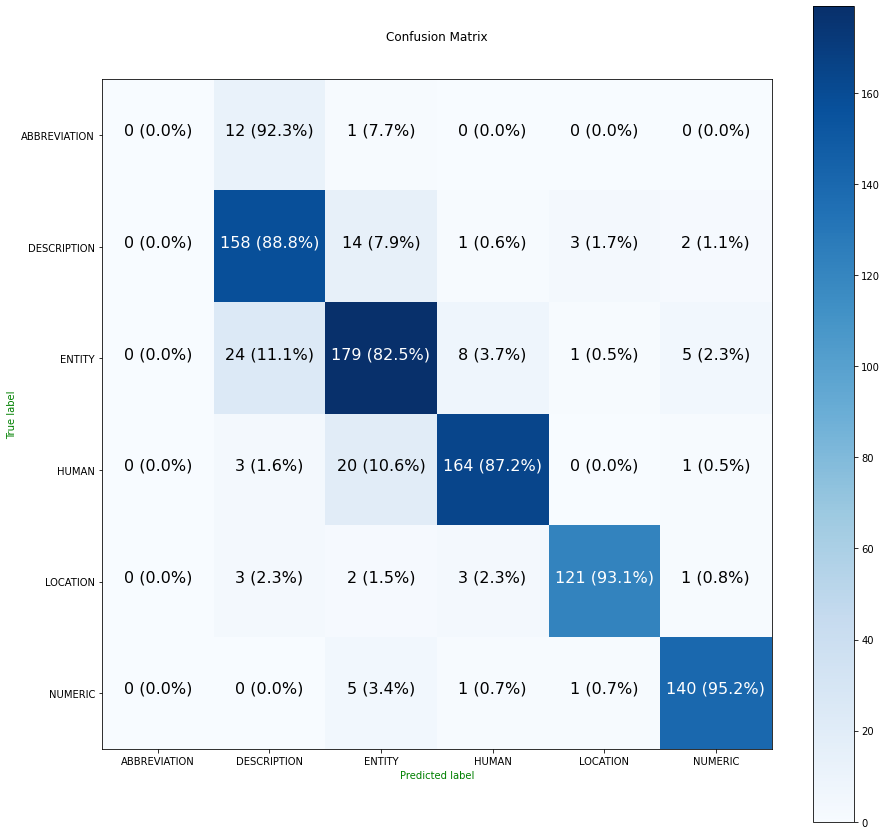

In [105]:
plot_confusion_matrix(test_labels, predictions, classes=class_names, figsize=(15, 15), text_size=16)

### Next.

We are going to use `Conv` nets to do this task.